In [2]:
!nvidia-smi

Mon Sep  9 13:31:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   56C    P0    47W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
PRFX = 'CVBbox0908_1'
PREP_PRFX = 'PrepBbox0908'

HOME = '/tmp/working/data/git/cld'
p_output = f'{HOME}/output/{PRFX}'
from pathlib import Path
Path(p_output).mkdir(exist_ok=True)


In [9]:
# cd {HOME}/input

# !git clone https://github.com/fizyr/keras-retinanet.git

# cd {HOME}/input/keras-retinanet/

# !python setup.py build_ext --inplace

# cd {HOME}/input/

# !wget --quiet https://github.com/fizyr/keras-retinanet/releases/download/0.3.1/resnet50_coco_best_v2.1.0.h5

# !pip install {HOME}/input/keras-retinanet --user

- https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/bin/train.py
- http://localhost:8889/notebooks/git/Research/imgcat/nbs/2018-07-05/retinanet_openimages-clothing-parts-crop.ipynb
- https://github.com/fizyr/keras-retinanet/blob/master/examples/ResNet50RetinaNet.ipynb

In [4]:
SEED = 100
PERC_VAL = 0.15
BS = 4
EPOCHS = 50
FN_LBLS = f'{HOME}/output/{PREP_PRFX}/lbls.csv'
SCORE_THRESHOLD = 0.5
INPUT_SHAPE = (1400, 2100)
IMAGE_MIN_SIDE, IMAGE_MAX_SIDE = [int(o/7*4) for o in (1400, 2100)]
print('IMAGE_MIN_SIDE, IMAGE_MAX_SIDE', IMAGE_MIN_SIDE, IMAGE_MAX_SIDE)
dbg = False
if dbg: 
    EPOCHS = 1
    dbgsz = 50

IMAGE_MIN_SIDE, IMAGE_MAX_SIDE 800 1200


In [5]:
import pandas as pd
import numpy as np
import pickle
from skimage.data import imread


# prep

In [15]:
col_names = ['Image', 'x1', 'y1', 'x2', 'y2', 'Label']
df_boxes = pd.read_csv(f'{HOME}/output/{PREP_PRFX}/boxes.csv', header=None, names=col_names)

df_boxes.head()

Image   x1   y1    x2    y2   Label
0  0011165.jpg  193  321  1179  1249    Fish
1  0011165.jpg  972  317  2090  1361  Flower
2  002be4f.jpg  171   13  2082   885    Fish
3  002be4f.jpg  960  882  2093  1392  Flower
4  002be4f.jpg   52  298   940   639   Sugar

In [16]:
if dbg: df_boxes = df_boxes.head(dbgsz)

In [17]:
df_boxes.Image = f'{HOME}/input/train_images/'+df_boxes.Image

In [18]:
imgs = np.array(list(set(df_boxes.Image)))

np.random.seed(SEED)
msk_val = np.random.rand(len(imgs))<PERC_VAL
imgs_trn = imgs[~msk_val]
imgs_val = imgs[msk_val]

print(len(imgs), len(imgs_trn), len(imgs_val))

df_boxes_trn = df_boxes[df_boxes.Image.isin(imgs_trn)]
df_boxes_val = df_boxes[df_boxes.Image.isin(imgs_val)]
print(df_boxes_trn.shape, df_boxes_val.shape)

steps = len(imgs_trn)//BS


5546 4684 862
(13860, 6) (2515, 6)


In [17]:
df_boxes_trn.to_csv(f'{HOME}/output/{PRFX}/boxes_trn.csv', index=False, header=None)
df_boxes_val.to_csv(f'{HOME}/output/{PRFX}/boxes_val.csv', index=False, header=None)

# train

In [26]:
!{HOME}/input/keras-retinanet/keras_retinanet/bin/train.py \
--weights $HOME/input/resnet50_coco_best_v2.1.0.h5 \
--epochs $EPOCHS \
--steps $steps \
--batch-size $BS \
--snapshot-path $p_output \
--compute-val-loss \
--random-transform \
--image-min-side $IMAGE_MIN_SIDE \
--image-max-side $IMAGE_MAX_SIDE \
csv {HOME}/output/{PRFX}/boxes_trn.csv $FN_LBLS --val-annotations {HOME}/output/{PRFX}/boxes_val.csv

Using TensorFlow backend.
2019-09-08 20:45:24.831376: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300065000 Hz
2019-09-08 20:45:24.831980: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x558ca351dc80 executing computations on platform Host. Devices:
2019-09-08 20:45:24.832014: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-08 20:45:25.556216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-09-08 20:45:25.557203: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x558ca35ed660 executing computations on platform CUDA. Devices:
2019-09-08 20:45:25.557243: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2019-09-08 20:45:25.558059: I tensorflow/core

bn3a_branch2b (BatchNormalizati (None, None, None, 1 512         res3a_branch2b[0][0]             
__________________________________________________________________________________________________
res3a_branch2b_relu (Activation (None, None, None, 1 0           bn3a_branch2b[0][0]              
__________________________________________________________________________________________________
res3a_branch2c (Conv2D)         (None, None, None, 5 65536       res3a_branch2b_relu[0][0]        
__________________________________________________________________________________________________
res3a_branch1 (Conv2D)          (None, None, None, 5 131072      res2c_relu[0][0]                 
__________________________________________________________________________________________________
bn3a_branch2c (BatchNormalizati (None, None, None, 5 2048        res3a_branch2c[0][0]             
__________________________________________________________________________________________________
bn3a_branc

Epoch 1/50
1171/1171 [==============================] - 2796s 2s/step - loss: 2.6753 - regression_loss: 2.0569 - classification_loss: 0.6184 - val_loss: 2.5654 - val_regression_loss: 2.0714 - val_classification_loss: 0.4940
Running network: N/A% (0 of 862) |       | Elapsed Time: 0:00:00 ETA:  --:--:--2019-09-08 21:32:23.824449: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node clipped_boxes/strided_slice_2. Error: Pack node (boxes/stack) axis attribute is out of bounds: 2
2019-09-08 21:32:23.824530: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOptimizer, stage RemoveStackStridedSliceSameAxis node clipped_boxes/strided_slice_3. Error: Pack node (boxes/stack) axis attribute is out of bounds: 2
2019-09-08 21:32:23.824568: W ./tensorflow/core/grappler/optimizers/graph_optimizer_stage.h:241] Failed to run optimizer ArithmeticOp

1171/1171 [==============================] - 2751s 2s/step - loss: 2.0763 - regression_loss: 1.6880 - classification_loss: 0.3883 - val_loss: 2.4446 - val_regression_loss: 2.0274 - val_classification_loss: 0.4172
Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:11 Time:  0:02:11
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
608 instances of class Gravel with average precision: 0.3367
608 instances of class Fish with average precision: 0.2846
484 instances of class Flower with average precision: 0.5605
811 instances of class Sugar with average precision: 0.4172
mAP: 0.3998

Epoch 00009: saving model to /tmp/working/data/git/cld/output/CVBbox0908_1/resnet50_csv_09.h5
Epoch 10/50
1171/1171 [==============================] - 2876s 2s/step - loss: 2.0687 - regression_loss: 1.6832 - classification_loss: 0.3855 - val_loss: 2.5304 - val_regression_loss: 2.1082 - val_classification_loss: 0.4222
Running network: 100% (862 of 862) |#####| Elapsed Tim

Running network: 100% (862 of 862) |#####| Elapsed Time: 0:02:23 Time:  0:02:23
Parsing annotations: 100% (862 of 862) |#| Elapsed Time: 0:00:00 Time:  0:00:00
608 instances of class Gravel with average precision: 0.3534
608 instances of class Fish with average precision: 0.2796
484 instances of class Flower with average precision: 0.5676
811 instances of class Sugar with average precision: 0.4254
mAP: 0.4065

Epoch 00020: saving model to /tmp/working/data/git/cld/output/CVBbox0908_1/resnet50_csv_20.h5
Epoch 21/50
1039/1171 [=========================>....] - ETA: 4:56 - loss: 1.9678 - regression_loss: 1.6009 - classification_loss: 0.3669^C
Traceback (most recent call last):
  File "/tmp/working/data/git/cld/input/keras-retinanet/keras_retinanet/bin/train.py", line 527, in <module>
    main()
  File "/tmp/working/data/git/cld/input/keras-retinanet/keras_retinanet/bin/train.py", line 522, in main
    validation_data=validation_generator
  File "/opt/conda/lib/python3.6/site-packages/kera

In [6]:
dd='19'

fn_mdl = f"resnet50_csv_{dd}.h5"
pth_mdl = f"{p_output}/{fn_mdl}"
pth_pred_mdl = f"{p_output}/prd_{fn_mdl}"

fn_mdl, pth_mdl, pth_pred_mdl

('resnet50_csv_19.h5',
 '/tmp/working/data/git/cld/output/CVBbox0908_1/resnet50_csv_19.h5',
 '/tmp/working/data/git/cld/output/CVBbox0908_1/prd_resnet50_csv_19.h5')

# pred

## demo

In [7]:
!{HOME}/input/keras-retinanet/keras_retinanet/bin/convert_model.py  $pth_mdl $pth_pred_mdl

Using TensorFlow backend.
2019-09-09 13:31:34.415361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300065000 Hz
2019-09-09 13:31:34.416077: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x55dbc5c32910 executing computations on platform Host. Devices:
2019-09-09 13:31:34.416121: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-09-09 13:31:35.281089: E tensorflow/stream_executor/cuda/cuda_driver.cc:300] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-09-09 13:31:35.281164: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:161] retrieving CUDA diagnostic information for host: 3bc68dcbbcdd
2019-09-09 13:31:35.281184: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:168] hostname: 3bc68dcbbcdd
2019-09-09 13:31:35.281288: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:192] libcuda reported version is: 418.56.0
2019-09-09 13:31:35.281330

In [10]:
from keras_retinanet.models import load_model
import time
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2

In [11]:
nm2lbl = dict(pd.read_csv(FN_LBLS, header=None).values)
lbl2nm = {v:k for k,v in nm2lbl.items()}

In [12]:
model = load_model(pth_pred_mdl, backbone_name='resnet50')

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
def demo_retinanet(img):
    print(img)
    # load image
    image = read_image_bgr(img)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    score_threshold_draw = 0.5
    score_threshold_print = 0.5
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if label < 0: continue
        if score < score_threshold_print: break
        print(lbl2nm[label], score)  
        if score < score_threshold_draw: continue
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(lbl2nm[label], score)
        draw_caption(draw, b, caption)
    plt.figure(figsize=(50, 50))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [25]:
img = df_boxes_val.Image.sample().values[0]

/tmp/working/data/git/cld/input/train_images/f0eebb6.jpg
processing time:  0.04388904571533203
Flower 0.74915385


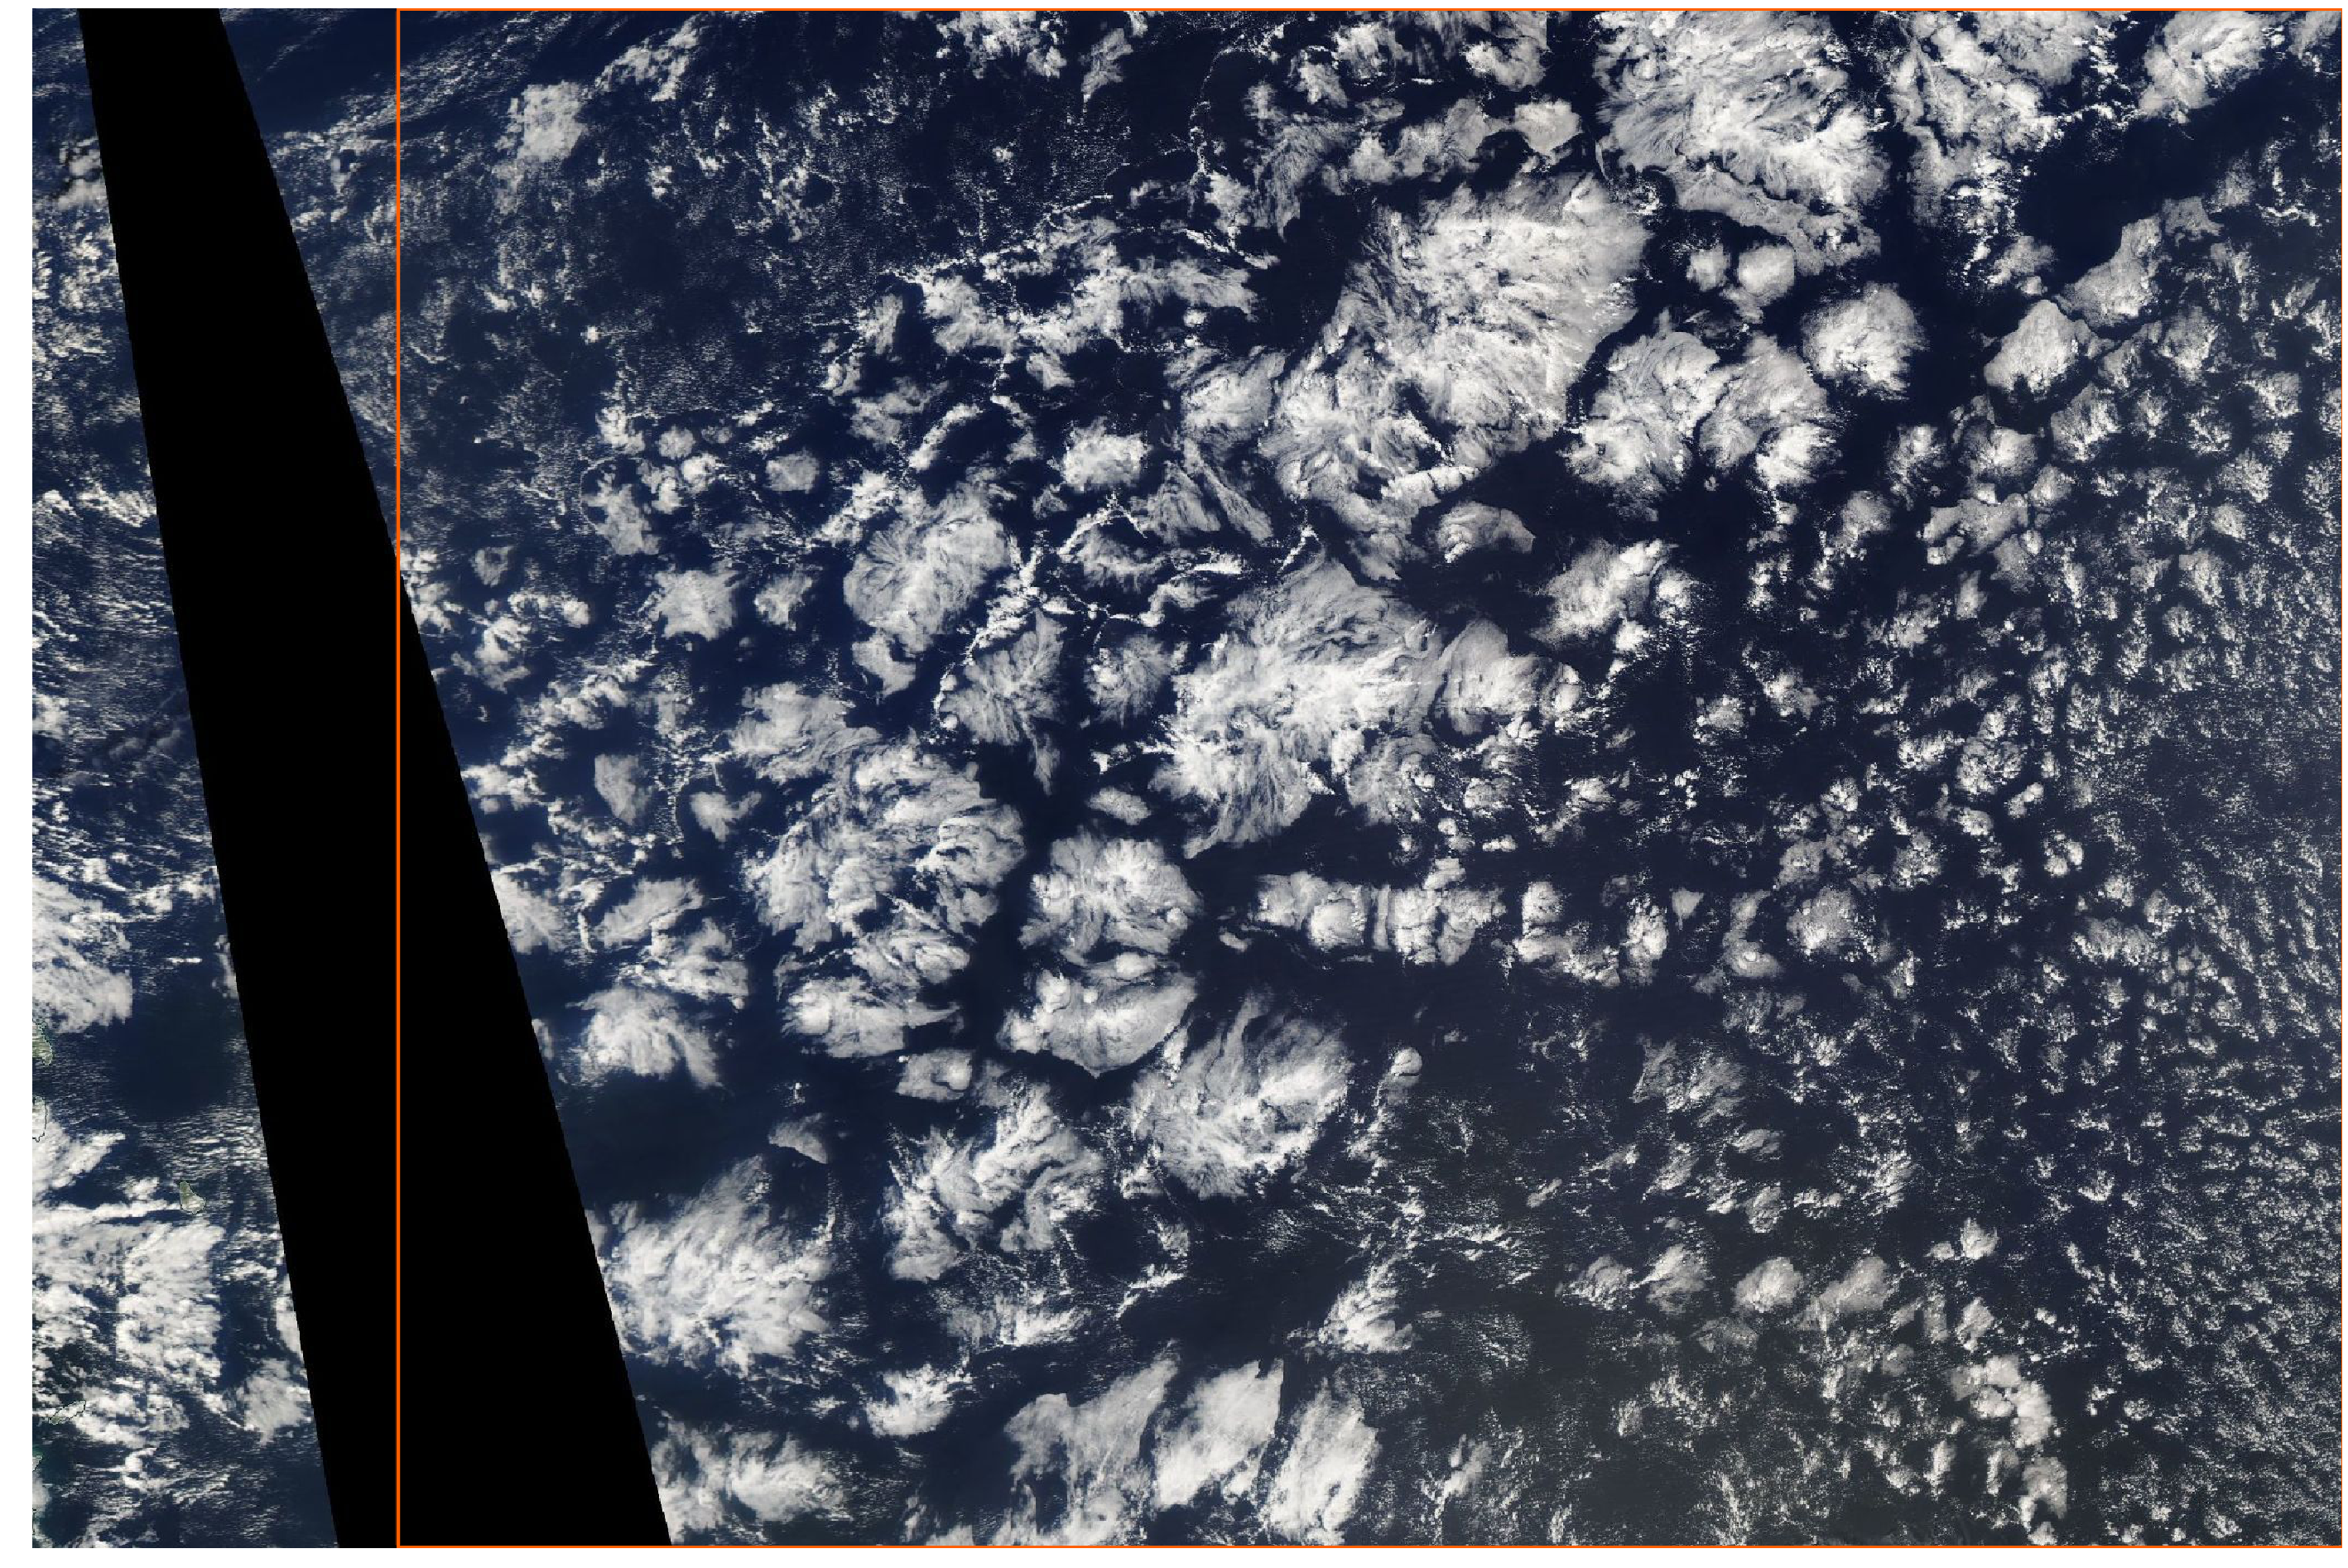

In [26]:
demo_retinanet(img)

## pred on test

In [27]:
import datetime

lst_res = [] 
test_images = list(Path(f'{HOME}/input/test_images').iterdir())
for i, fn_img in enumerate(test_images):
    if (i+1)%100==0: 
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} {i+1}/{len(test_images)}")

    image = read_image_bgr(fn_img)
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    # correct for image scale
    boxes /= scale
    lst_res.append((boxes, scores, labels))

2019-09-09 13:54:46 100/3698
2019-09-09 13:55:01 200/3698
2019-09-09 13:55:16 300/3698
2019-09-09 13:55:31 400/3698
2019-09-09 13:55:46 500/3698
2019-09-09 13:56:01 600/3698
2019-09-09 13:56:16 700/3698
2019-09-09 13:56:31 800/3698
2019-09-09 13:56:46 900/3698
2019-09-09 13:57:01 1000/3698
2019-09-09 13:57:16 1100/3698
2019-09-09 13:57:31 1200/3698
2019-09-09 13:57:45 1300/3698
2019-09-09 13:58:00 1400/3698
2019-09-09 13:58:15 1500/3698
2019-09-09 13:58:30 1600/3698
2019-09-09 13:58:45 1700/3698
2019-09-09 13:59:00 1800/3698
2019-09-09 13:59:15 1900/3698
2019-09-09 13:59:29 2000/3698
2019-09-09 13:59:44 2100/3698
2019-09-09 13:59:59 2200/3698
2019-09-09 14:00:14 2300/3698
2019-09-09 14:00:30 2400/3698
2019-09-09 14:00:45 2500/3698
2019-09-09 14:01:00 2600/3698
2019-09-09 14:01:16 2700/3698
2019-09-09 14:01:31 2800/3698
2019-09-09 14:01:46 2900/3698
2019-09-09 14:02:01 3000/3698
2019-09-09 14:02:16 3100/3698
2019-09-09 14:02:31 3200/3698
2019-09-09 14:02:47 3300/3698
2019-09-09 14:03:02

In [28]:
fn_mdl = f"resnet50_csv_{dd}.h5"
pth_res = f"{p_output}/{fn_mdl}_res.p"
pickle.dump(lst_res, open(pth_res, 'wb'))

In [29]:
lst_res = pickle.load(open(pth_res, 'rb'))

In [30]:
score_threshold = SCORE_THRESHOLD
lst_res2keep = []
for res in lst_res:
    res2keep = []
    # visualize detections
    boxes, scores, labels = [o[0] for o in res]
    for box, score, label in zip(boxes, scores, labels):
        # scores are sorted so we can break
        if label < 0: continue
        if score < score_threshold: break
        box = box.astype(int)
        res2keep.append((box, score, label))
    lst_res2keep.append(res2keep)

In [31]:
len(lst_res2keep)

3698

In [32]:
lst_res2keep[:10]

[[(array([ 502,    0, 1727,  690]), 0.53880143, 3)],
 [(array([1130, 1011, 2100, 1399]), 0.5789608, 2),
  (array([  43,    0, 1122, 1135]), 0.5444854, 3)],
 [(array([   0,    0, 1379, 1036]), 0.5573842, 0)],
 [(array([1559,  217, 2100, 1027]), 0.55606234, 2)],
 [(array([ 702,    0, 2100,  741]), 0.69992566, 2),
  (array([1387, 1100, 2100, 1399]), 0.6241576, 2),
  (array([ 294,  515, 1681, 1233]), 0.6013494, 3)],
 [(array([ 556,  216, 2100, 1364]), 0.69136405, 3),
  (array([  25,  719,  429, 1399]), 0.5272464, 3)],
 [(array([1691,  232, 2100, 1399]), 0.72342855, 2)],
 [(array([   0,  266, 1239, 1399]), 0.52926147, 3),
  (array([1264,  697, 2100, 1399]), 0.5033501, 1)],
 [],
 [(array([ 654,    0, 1659,  447]), 0.545256, 2)]]

## box2 rle

In [33]:
def rle2box(mask_rle, shape=INPUT_SHAPE):
    img_msk = rle2mask(mask_rle)
    [(y_1, y_2), (x_1, x_2)]= [(o.min(), o.max()) for o in np.where(img_msk==1)]
    return x_1, y_1, x_2, y_2


def rle2mask(mask_rle, shape=INPUT_SHAPE):
    '''
    mask_rle: run-length as string formatted (start length)
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img_msk = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img_msk[lo:hi] = 1
    return img_msk.reshape(shape, order='F')  # Needed to align to RLE direction

# https://www.kaggle.com/xhlulu/satellite-clouds-u-net-with-resnet-encoder
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# https://www.kaggle.com/zhangyang/clddevbboxmask0906-1


def box2mask(box, shape=INPUT_SHAPE):
    x_1, y_1, x_2, y_2 = box
    mask = np.zeros(shape)
    mask[y_1:y_2, x_1:x_2]=1
    return mask

def box2rle(box, img=None, shape=INPUT_SHAPE):
    mask = box2mask(box, shape)
    if img is not None: mask[img.sum(-1)==0]=0
    mask_rle = mask2rle(mask)
    return mask_rle

In [34]:
lbl2i = dict(pd.read_csv(FN_LBLS, header=None).values)
i2lbl = {v:k for k,v in lbl2i.items()}
i2lbl

{0: 'Gravel', 1: 'Fish', 2: 'Flower', 3: 'Sugar'}

In [35]:
res_subm = []
for i, fn_img in enumerate(test_images):
    if (i+1)%100==0: 
        print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} {i+1}/{len(test_images)}")
    res = lst_res2keep[i]
    if len(res)==0: continue
    img = imread(fn_img)
    for box, score, i_lbl in res:
        predicted_rle = box2rle(box, img=img)
        lbl = i2lbl[i_lbl]
        res_subm.append((f'{fn_img.stem}.jpg_{lbl}', predicted_rle))

2019-09-09 14:04:03 100/3698
2019-09-09 14:04:22 200/3698
2019-09-09 14:04:40 300/3698
2019-09-09 14:04:56 400/3698
2019-09-09 14:05:12 500/3698
2019-09-09 14:05:31 600/3698
2019-09-09 14:05:47 700/3698
2019-09-09 14:06:06 800/3698
2019-09-09 14:06:25 900/3698
2019-09-09 14:06:41 1000/3698
2019-09-09 14:06:59 1100/3698
2019-09-09 14:07:16 1200/3698
2019-09-09 14:07:33 1300/3698
2019-09-09 14:07:51 1400/3698
2019-09-09 14:08:08 1500/3698
2019-09-09 14:08:24 1600/3698
2019-09-09 14:08:39 1700/3698
2019-09-09 14:08:57 1800/3698
2019-09-09 14:09:14 1900/3698
2019-09-09 14:09:32 2000/3698
2019-09-09 14:09:47 2100/3698
2019-09-09 14:10:03 2200/3698
2019-09-09 14:10:18 2300/3698
2019-09-09 14:10:34 2400/3698
2019-09-09 14:10:53 2500/3698
2019-09-09 14:11:10 2600/3698
2019-09-09 14:11:25 2700/3698
2019-09-09 14:11:42 2800/3698
2019-09-09 14:11:59 2900/3698
2019-09-09 14:12:14 3000/3698
2019-09-09 14:12:31 3100/3698
2019-09-09 14:12:46 3200/3698
2019-09-09 14:13:02 3300/3698
2019-09-09 14:13:16

In [36]:
dct_res_subm = dict(res_subm)

## submission

In [37]:
sample_submission = pd.read_csv(f'{HOME}/input/sample_submission.csv')
sample_submission.head()

Image_Label EncodedPixels
0    002f507.jpg_Fish           1 1
1  002f507.jpg_Flower           1 1
2  002f507.jpg_Gravel           1 1
3   002f507.jpg_Sugar           1 1
4    0035ae9.jpg_Fish           1 1

In [38]:
len(test_images), len(test_images)*4, sample_submission.shape, len(res_subm)

(3698, 14792, (14792, 2), 4420)

In [39]:
for i, image_label in enumerate(sample_submission.Image_Label):
    sample_submission.EncodedPixels[i] = dct_res_subm.get(image_label, '')

In [40]:
sample_submission.head()

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 1317 1401 1317 2801 1317 4201 1317 5601 1317...
3   002f507.jpg_Sugar                                                   
4    0035ae9.jpg_Fish

In [41]:
sample_submission.sample(5)

Image_Label EncodedPixels
11148    c27cfb7.jpg_Fish              
4705   5097ff1.jpg_Flower              
10204    b2014b1.jpg_Fish              
11897  cf543b6.jpg_Flower              
10865  bd41f7b.jpg_Flower

In [42]:
f'{p_output}/{PRFX}_{fn_mdl}_submission.csv'

'/tmp/working/data/git/cld/output/CVBbox0908_1/CVBbox0908_1_resnet50_csv_19.h5_submission.csv'

In [43]:
sample_submission.to_csv(f'{p_output}/{PRFX}_{fn_mdl}_submission.csv', index=False)